In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from pathlib import Path

from lola.plot import draw

outdir = Path("./figures")
outdir.mkdir(exist_ok=True)

rc = {
    "axes.axisbelow": True,
    "axes.linewidth": 1.0,
    "axes.labelsize": "x-small",
    "axes.titlesize": "x-small",
    "figure.dpi": 150,
    "figure.figsize": (3.2, 3.2),
    "font.size": 12.0,
    "legend.fontsize": "xx-small",
    "lines.linewidth": 1.0,
    "savefig.transparent": True,
    "xtick.labelsize": "xx-small",
    "xtick.major.width": 1.0,
    "ytick.labelsize": "xx-small",
    "ytick.major.width": 1.0,
    "font.family": ["serif"],
    # 'text.usetex': True,
    # 'text.latex.preamble': r"\usepackage{amsfonts}",
}

plt.rcParams.update(rc)

## Dataframe

In [2]:
df = pd.read_csv(
    "~/ceph/lola/results/rayleigh_benard/stats.csv",
    names=[
        "run",
        "target",
        "compression",
        "method",
        "settings",
        "guidance",
        "context",
        "overlap",
        "speed",
        "split",
        "index",
        "start",
        "seed",
        "field",
        "time",
        "auto_encoded",
        "m1",
        "m2",
        "spread",
        "rmse",
        "nrmse",
        "vrmse",
        "re_total",
        "rmse_p_low",
        "rmse_c_low",
        "rmse_p_mid",
        "rmse_c_mid",
        "rmse_p_high",
        "rmse_c_high",
        "rmse_p_sub",
        "rmse_c_sub",
        "rayleigh",
        "prandtl",
        "bc00",
        "bc01",
        "bc10",
        "bc11",
    ],
    dtype={"settings": str, "guidance": str, "compression": int},
)

df = df[~df["auto_encoded"]]
df = df[df["time"] > 0]
df = df[df["start"] == 32]
df = df.sort_values(["method", "compression"], kind="stable")
df = df.merge(
    pd.DataFrame({
        "field": [0, 1, 2, 3],
        "std_global": [0.25, 0.15, 0.20, 0.20],
    })
)


def horizon(t):
    if t < 20:
        return "1:20"
    elif t < 60:
        return "21:60"
    else:
        return "61:160"


df["horizon"] = df["time"].apply(horizon)
df["std_instant"] = np.sqrt(df["m2"] - df["m1"] ** 2)
df["coverage"] = (df["spread"] + 1e-3) / (df["rmse"] + 1e-3)
df.loc[df["method"] == "surrogate", "coverage"] = 0.0

To aggregate the metrics of different fields, we use a weighted average where the weights are the fields' instantaneous std, relative to the fields' global std.

In [3]:
weight = df["std_instant"] / df["std_global"]


def weighted_mean(x):
    w = weight[x.index]
    return np.mean(x * w) / np.mean(w)

## Plots

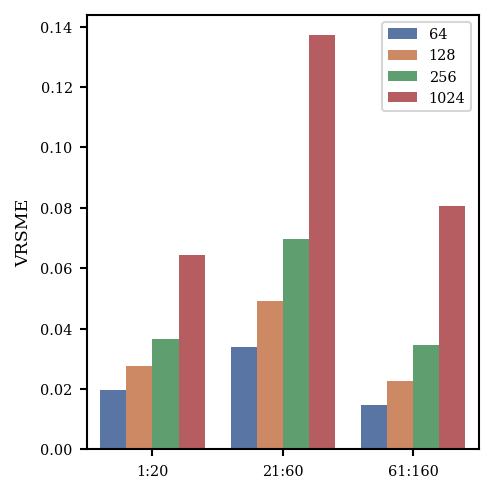

In [4]:
table = df[df["method"] == "autoencoder"]

fig = plt.figure(figsize=(3.2, 3.2))

ax = sb.barplot(
    table,
    x="horizon",
    y="vrmse",
    hue="compression",
    estimator=weighted_mean,
    errorbar=None,
    palette=sb.color_palette("deep", 4),
)

ax.get_legend().set_title(None)

ax.set_xlabel(None)
ax.set_ylabel("VRSME")

fig.tight_layout(pad=0.33)

plt.savefig(outdir / "rb_ae.pdf", dpi=300, transparent=True)

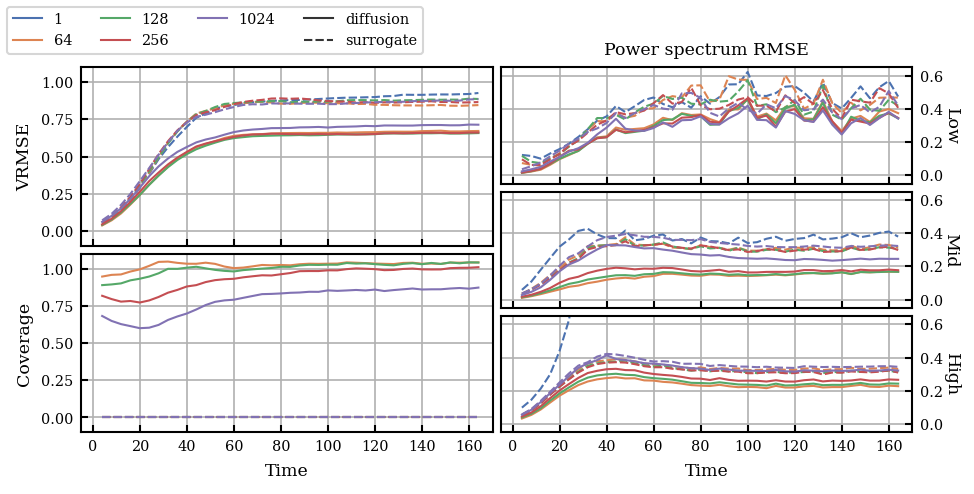

In [5]:
table = df[df["method"] != "autoencoder"]

fig, axs = plt.subplot_mosaic(
    [
        [0, 2],
        [0, 2],
        [0, 3],
        [1, 3],
        [1, 4],
        [1, 4],
    ],
    figsize=(6.4, 3.2),
    sharex=True,
    sharey=False,
)

for i, metric in enumerate(["VRMSE", "Coverage"]):
    ax = sb.lineplot(
        table,
        x="time",
        y=metric.lower(),
        hue="compression",
        style="method",
        estimator=weighted_mean,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Time")
    ax.set_xlim(-5, 170)

    ax.set_ylabel(metric)
    ax.set_ylim(-0.1, 1.1)

    ax.tick_params(direction="in")

    handles, labels = ax.get_legend_handles_labels()

for i, band in enumerate(["Low", "Mid", "High"], start=2):
    ax = sb.lineplot(
        table,
        x="time",
        y=f"rmse_p_{band.lower()}",
        hue="compression",
        style="method",
        estimator=weighted_mean,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Time")
    ax.set_xlim(-5, 170)

    ax.set_ylabel(band)
    ax.set_ylim(-0.05, 0.65)

    ax.tick_params(direction="in")

    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set(rotation=-90, va="center")
    ax.yaxis.tick_right()

    if i == 2:
        ax.set_title("Power spectrum RMSE")

for i, label in reversed(list(enumerate(labels))):
    if label in ("compression", "method"):
        blank = handles.pop(i)
        labels.pop(i)

handles.insert(-2, blank)
labels.insert(-2, None)

fig.align_labels()
fig.tight_layout(pad=0.33)
fig.subplots_adjust(top=0.875)
fig.legend(handles, labels, loc="upper left", ncol=4)

plt.savefig(outdir / "rb_mosaic.pdf", dpi=300, transparent=True)

## Tables

In [6]:
table = df[["method", "compression", "horizon", "vrmse"]]

table = table.groupby(["method", "compression", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                   1:20  21:60 61:160
method      compression                     
autoencoder 64           0.020  0.034  0.015
            128          0.027  0.049  0.023
            256          0.036  0.070  0.034
            1024         0.064  0.137  0.081
diffusion   64           0.104  0.485  0.662
            128          0.109  0.478  0.648
            256          0.117  0.494  0.653
            1024         0.136  0.526  0.700
surrogate   1            0.121  0.642  0.896
            64           0.124  0.661  0.852
            128          0.132  0.662  0.875
            256          0.140  0.663  0.871
            1024         0.157  0.657  0.863

In [7]:
table = df[(df["method"] != "autoencoder") & (df["compression"] > 1)]
table = table[["method", "context", "horizon", "vrmse"]]

table = table.groupby(["method", "context", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(index=["method", "context"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon             1:20  21:60 61:160
method    context                     
diffusion 1        0.118  0.500  0.668
          2        0.117  0.494  0.668
          3        0.115  0.493  0.661
surrogate 1        0.136  0.639  0.856
          2        0.138  0.653  0.854
          3        0.141  0.690  0.886

In [8]:
table = df[["method", "compression", "horizon", "rmse_p_low", "rmse_p_mid", "rmse_p_high"]]

table = table.groupby(["method", "compression", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(
    index=["method", "compression"],
    columns="horizon",
    values=["rmse_p_low", "rmse_p_mid", "rmse_p_high"],
)
# print(table.to_latex(float_format="%.3f"))
table

rmse_p_low               rmse_p_mid                \
horizon                       1:20  21:60 61:160       1:20  21:60 61:160   
method      compression                                                     
autoencoder 64               0.002  0.001  0.001      0.006  0.015  0.009   
            128              0.003  0.003  0.001      0.014  0.054  0.030   
            256              0.006  0.005  0.003      0.026  0.116  0.073   
            1024             0.015  0.022  0.014      0.059  0.264  0.207   
diffusion   64               0.035  0.221  0.362      0.029  0.110  0.154   
            128              0.039  0.213  0.352      0.035  0.128  0.158   
            256              0.040  0.218  0.346      0.043  0.166  0.175   
            1024             0.050  0.236  0.333      0.070  0.285  0.255   
surrogate   1                0.118  0.329  0.487      0.154  0.380  0.371   
            64               0.075  0.300  0.476      0.090  0.309  0.312   
            128              0.094  0.305  0.433      0.085  0.300  0.305   
            256              0.080  0.299  0.442      0.082  0.296  0.305   
            1024             0.073  0.298  0.417      0.088  0.340  0.332   

                        rmse_p_high                
horizon                        1:20  21:60 61:160  
method      compression                            
autoencoder 64                0.064  0.211  0.170  
            128               0.079  0.252  0.209  
            256               0.092  0.289  0.249  
            1024              0.116  0.357  0.323  
diffusion   64                0.079  0.253  0.230  
            128               0.087  0.274  0.244  
            256               0.097  0.300  0.267  
            1024              0.118  0.359  0.327  
surrogate   1                 0.194  1.018  0.982  
            64                0.120  0.353  0.335  
            128               0.112  0.342  0.319  
            256               0.112  0.337  0.316  
            1024              0.124  0.376  0.350

## Images

In [9]:
path = Path("/mnt/ceph/users/frozet/lola/videos/rayleigh_benard")

runs = df[["run", "method", "compression"]]
runs = runs.drop_duplicates()

field = 0
frames = np.array([0, 2, 4, 8, 16, 32])

for run, method, compression in runs.values:
    files = (path / run).glob("*032*.npz")
    files = sorted(files)

    for i, file in enumerate(files):
        x, x_hat = np.load(file).values()

        x = x[field, frames, ::2, :]
        x_hat = x_hat[:, field, frames, ::2, :]

        vmin = np.nanquantile(x, 0.01, keepdims=True) - 1e-2
        vmax = np.nanquantile(x, 0.99, keepdims=True) + 1e-2

        draw(x, vmin=vmin, vmax=vmax, pad=8).save(outdir / f"rb_{i}_gt.png")

        for j in range(len(x_hat)):
            draw(x_hat[j], vmin=vmin, vmax=vmax, pad=8).save(outdir / f"rb_{i}_{method}_{compression:04d}_{j}.png")